(xarray_intro)=
# Xarray for Exploratory Analysis of Bayesian Models

:::{post} July 13, 2023
:category: python, xarray
:tags: data storage, recommendation
:exclude:

Tutorial style introduction to xarray features: dimensions, coordinates, indexes, plotting and more...
:::

:::{image} ../post_images/hmm_drive.png
:alt:
:class: hidden-metadata
:::

Xarray provides two data structures: <inv:#xarray.DataArray> and <inv:#xarray.Dataset>. Both support named dimensions, coordinates and, more recently, also explicit indexes.
A `DataArray` can be seen as an extension of an n-dimensional array like a <inv:#numpy.ndarray>. A `DataSet` can be seen as an extension of a flat dictionary of arrays.

In this post we will cover dimensions, coordinates and indexes, especially for `DataArray` objects but also for `Dataset` objects. Xarray also supports attaching arbitrary metadata to `DataArray`s, `Dataset`s and even coordinates. The arrays we'll generate will have random values, so we won't care much about the values themselves, and we won't cover attributes in this post either, so we will configure the html view of xarray objects to show indexes by default and hide attributes:

In [1]:
import numpy as np
import xarray as xr

xr.set_options(display_expand_data=False, display_expand_indexes=True, display_expand_attrs=False);

## DataArray
### Dimensions
For me, the most important feature is the ability to label dimensions. Given an array, we can assign a label to each of its dimensions (axes in NumPy terminology):

In [2]:
ary = np.random.default_rng().normal(size=(4, 100, 7, 24))
da_dims = xr.DataArray(ary, dims=["chain", "draw", "person", "time"])
da_dims

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
0.7451 0.2808 0.441 -0.4225 0.0954 ... 0.005069 -0.9218 -0.4216 1.484 0.4003
Dimensions without coordinates: chain, draw, person, time

We now have the same data as in the array `ary` with its dimensions labeled. That means we can indicate operations over specific dimensions using their names instead of positional indicators. For example:

In [3]:
da_dims.mean(dim=("chain", "draw"))
# instead of ary.mean(axis=(0, 1))

<xarray.DataArray (person: 7, time: 24)>
0.01736 0.03742 -0.01866 -0.009007 ... 0.003847 -0.06927 -0.01463 -0.06731
Dimensions without coordinates: person, time

Having this information also allows xarray to perform automatic broadcasting:

In [4]:
da_persons = xr.DataArray(np.arange(7), dims="person")
da_dims + da_persons
# instead of ary + np.arange(13)[..., :, None]

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
0.7451 0.2808 0.441 -0.4225 0.0954 0.01268 ... 5.995 6.005 5.078 5.578 7.484 6.4
Dimensions without coordinates: chain, draw, person, time

Still, for the most part, `DataArray`s are interchangeable with ndarrays, even for functions that don't support `DataArray`s explicitly:

In [5]:
np.fft.rfft(da_dims, n=8, axis=2)

array([[[[ 1.30224905e+00+0.j        ,  2.52525839e+00+0.j        ,
          -2.86995820e+00+0.j        , ...,
          -2.89763776e+00+0.j        , -1.48852063e+00+0.j        ,
           9.63826722e-01+0.j        ],
         [-1.31740773e+00+1.6040512j , -2.20394324e+00+0.38791194j,
          -2.37762554e-01+2.48202087j, ...,
           2.15893621e+00-0.97640363j, -1.22811711e+00-3.19304711j,
           1.96508665e+00+2.08069316j],
         [ 1.55695151e+00-0.08968119j,  1.73965440e+00+1.72020926j,
           2.33949147e+00-1.41355782j, ...,
          -1.44919418e+00+1.88058307j, -1.16250300e+00+2.18321846j,
          -3.01333712e+00-1.94347851j],
         [-2.05290449e+00+2.7250933j , -2.78373063e+00-0.78979862j,
           3.56765382e-01+3.18813044j, ...,
           6.28573525e-01+1.85132532j, -2.46422367e-01+1.18466593j,
           2.73903130e+00-0.22097249j],
         [ 8.28537103e+00+0.j        ,  6.21726651e+00+0.j        ,
           1.48094156e+00+0.j        , ...,
        

It is possible to convert a `DataArray` to an ndarray using `da.values` but as we have just seen, very often it is not necessary.

### Coordinates and indexes
In addition, it is also possible to use coordinates. For `DataArray`s, coordinates are kind of in between data and attributes.
A `DataArray` is equivalent to a single array, however, it can have as many coordinates as desired. When creating a `DataArray`,
the `coords` argument can be used to initialize the coordinates. It is a dictionary whose keys are coordinate names,
and its values are `DataArray`s, arrays or tuples:

In [6]:
ary = np.random.default_rng().normal(size=(4, 100, 7, 24))
da = xr.DataArray(
    ary,
    dims=["chain", "draw", "person", "time"],
    coords={
        "chain": [1, 2, 3, 4],
        "gender": ("person", ["male", "neutrois", "female", "male", "NB", "female", "female"]),
        "age": ("person", [25, 30, 73, 47, 51, 20, 64]),
    }
)
da

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
0.1593 0.8005 -1.29 -2.006 1.854 ... -1.514 -0.3169 0.7084 -1.212 -0.01661
Coordinates:
  * chain    (chain) int64 1 2 3 4
    gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
Dimensions without coordinates: draw, person, time

Alternatively, <inv:#xarray.DataArray.assign_coords> can be used to add coordinates to an existing `DataArray`:

In [7]:
da = da.assign_coords(city=("person", ["Lleida", "Leida", "Sau", "Lleida", "Reus", "Sau", "Reus"]))
da

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
0.1593 0.8005 -1.29 -2.006 1.854 ... -1.514 -0.3169 0.7084 -1.212 -0.01661
Coordinates:
  * chain    (chain) int64 1 2 3 4
    gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
    city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

So far we have added all these coordinates, but we can't yet use that information directly for, say, slicing. Only the values of `chain` can be used for that,
hence it being bold in the "Coordinates" section and appearing in the "Indexes" section. To use the rest of the coordinates for slicing too, we need to 
indicate that to xarray:

In [8]:
da = da.set_xindex("gender").set_xindex("city")
da

<xarray.DataArray (chain: 4, draw: 100, person: 7, time: 24)>
0.1593 0.8005 -1.29 -2.006 1.854 ... -1.514 -0.3169 0.7084 -1.212 -0.01661
Coordinates:
  * chain    (chain) int64 1 2 3 4
  * gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
  * city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

We can slice along the `person` dimension using the `gender` coordinate:

In [9]:
da.sel(gender="female")

<xarray.DataArray (chain: 4, draw: 100, person: 3, time: 24)>
-1.342 -0.09653 0.4141 0.8698 0.1771 ... -1.514 -0.3169 0.7084 -1.212 -0.01661
Coordinates:
  * chain    (chain) int64 1 2 3 4
  * gender   (person) <U8 'female' 'female' 'female'
    age      (person) int64 73 20 64
  * city     (person) <U6 'Sau' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

### Vectorized and outer indexing
NumPy indexing is extremely powerful, especially what is often called "fancy" indexing. However, it can be confusing and inconsistent (see [this NEP proposal](https://numpy.org/neps/nep-0021-advanced-indexing.html) for more background). With dimensions and coordinates, xarray allows being explicit and consistent when choosing between vectorized and outer indexing.

Outer indexing selects rectangular or hyper-rectangular slices. To use outer indexing with xarray, we can use lists, arrays or `DataArray`s that have as a dimension the one that is being indexed:

In [10]:
da.sel(chain=[1, 3], time=slice(0, 5))

<xarray.DataArray (chain: 2, draw: 100, person: 7, time: 5)>
0.1593 0.8005 -1.29 -2.006 1.854 0.8185 ... 0.2008 0.1172 -0.03267 1.459 -1.425
Coordinates:
  * chain    (chain) int64 1 3
  * gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
  * city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: draw, person, time

Vectorized indexing selects only the exact positions being indicated by the indexing arrays. To do that we have to use `DataArray`s with dimensions different than those being indexed:

In [11]:
chain_idx = xr.DataArray([1, 1, 3, 3, 1, 3, 1, 1], dims="vectorized_sel")
time_idx = xr.DataArray([0, 1, 0, 1, 2, 2, 3, 4], dims="vectorized_sel")
da.sel(chain=chain_idx, time=time_idx)

<xarray.DataArray (vectorized_sel: 8, draw: 100, person: 7)>
0.1593 0.8185 -1.342 0.05015 -0.06136 ... -0.646 0.27 0.02266 -1.286 -0.6028
Coordinates:
    chain    (vectorized_sel) int64 1 1 3 3 1 3 1 1
  * gender   (person) <U8 'male' 'neutrois' 'female' ... 'NB' 'female' 'female'
    age      (person) int64 25 30 73 47 51 20 64
  * city     (person) <U6 'Lleida' 'Leida' 'Sau' 'Lleida' 'Reus' 'Sau' 'Reus'
Dimensions without coordinates: vectorized_sel, draw, person

### Plotting
Xarray also has some plotting support, which is very convenient for visualizing the multidimensional data. For example:

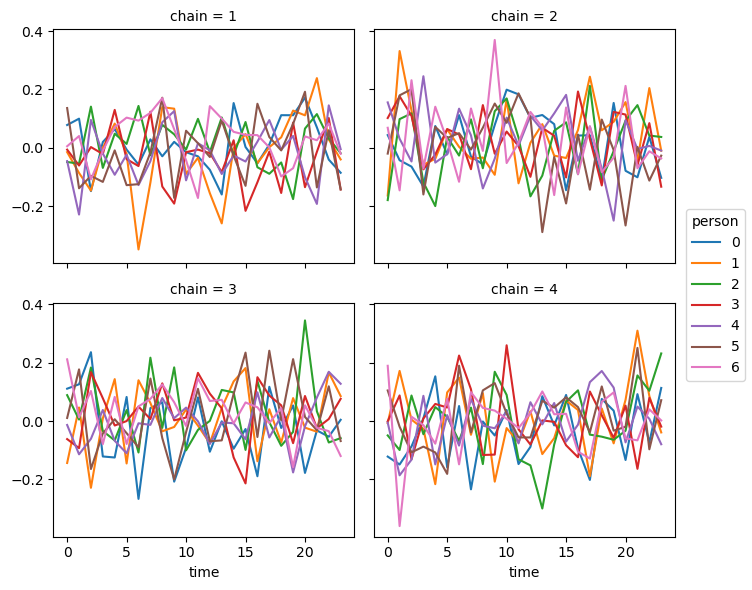

In [16]:
da.mean("draw").plot.line(x="time", hue="person", col="chain", col_wrap=2);

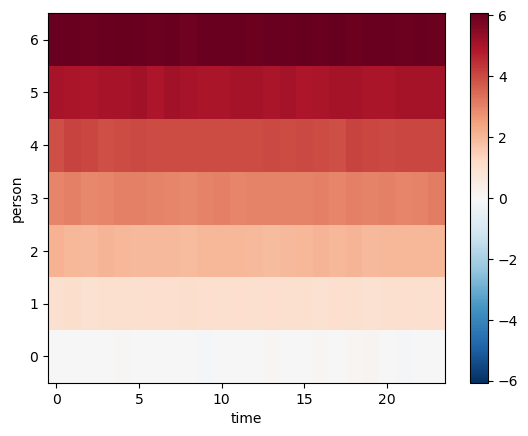

In [13]:
(da_dims + da_persons).mean(("chain", "draw")).plot.imshow(x="time", y="person");

## Dataset
`Dataset`s are a collection of `DataArray`s, each `DataArray` being a data variable and having a name/key. Thus, they are similar to a dictionary of arrays but with one important difference. Dimensions with the same name are shared between variables:

In [14]:
ds = xr.Dataset(
    {
        "a": (["chain", "draw", "person", "time"], ary),
        "b": (["chain", "draw"], np.random.default_rng().normal(size=(4, 100)))
    },
    coords={"chain": [1, 2, 3, 4]}
)
ds

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 100, person: 7, time: 24)
Coordinates:
  * chain    (chain) int64 1 2 3 4
Dimensions without coordinates: draw, person, time
Data variables:
    a        (chain, draw, person, time) float64 0.1593 0.8005 ... -0.01661
    b        (chain, draw) float64 -0.2445 0.1273 -0.6407 ... -0.5791 0.4282

They work very similarly to `DataArray`s, with operations being applied to all data variables in the `Dataset` (if reasonable). For example, if we index along the chain dimension, the operation applies to all two variables. However, taking the mean over the person dimension only affects the data variable `a`:

In [15]:
ds.sel(chain=2).mean("person")

<xarray.Dataset>
Dimensions:  (draw: 100, time: 24)
Coordinates:
    chain    int64 2
Dimensions without coordinates: draw, time
Data variables:
    a        (draw, time) float64 0.5318 0.02909 0.07919 ... 0.1611 0.1878
    b        (draw) float64 -1.362 2.0 -0.8794 2.452 ... -0.6956 0.4787 -0.07135